Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 1.9537
Epoch [2/2], Loss: 1.6111
Training Complete!

Model Performance -
Training Accuracy: 0.474
Training Precision (macro): 0.481
Training Recall (macro): 0.474
Validation Accuracy: 0.48
Validation Precision (macro): 0.486
Validation Recall (macro): 0.48


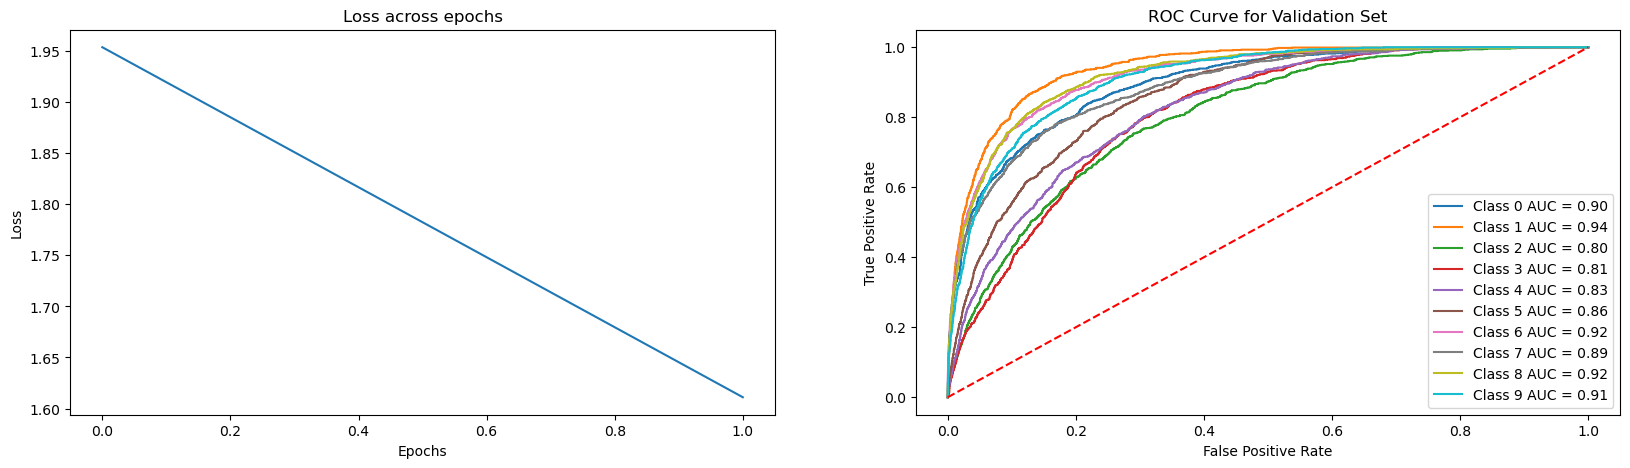

In [4]:
import torchvision
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)



# convert to nparray and normalize 
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomRotation(10),            # random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2,    # random changes in brightness, contrast, etc.
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),                    # ronvert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),    # ormalize to [-1, 1]
                         (0.5, 0.5, 0.5))
])

# get dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)                           #  pooling layer

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)                   # fully connected layer
        self.fc2 = nn.Linear(256, 10)                           # output layer 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1 -> ReLU -> Pool
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv2(x)))  # conv2 -> ReLU -> Pool
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)            # flatten the output
        x = F.relu(self.fc1(x))               # fully connected -> ReLU
        x = self.dropout2(x)

        x = self.fc2(x)                       # fully connected -> out
        return x
    
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer =optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train_model(model, train_loader, loss_function, optimizer, num_epochs=5):
    loss_list = []  # Initialize an empty list to store the average loss per epoch
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_train, y_train in train_loader:
            optimizer.zero_grad()            # Zero the gradients
            outputs = model(X_train)         # Forward pass
            loss = loss_function(outputs, y_train)  # Compute loss
            loss.backward()                  # Backward pass
            optimizer.step()                 # Update weights
            train_loss += loss.item()
        
        # Compute and save the average loss for this epoch
        average_loss = train_loss / len(train_loader)
        loss_list.append(average_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    
    print("Training Complete!")
    return loss_list  # Return the loss list






# Function to evaluate the model
def evaluate_model(model, train_loader, test_loader, loss_list):
    model.eval()  # Explicitly set to evaluation mode
    
    # Helper function to predict probabilities and labels
    def get_predictions(loader):
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Probabilities
                preds = torch.argmax(probs, dim=1)     # Predicted labels
                
                all_labels.extend(labels.numpy())
                all_preds.extend(preds.numpy())
                all_probs.extend(probs.numpy())
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)
    
    # Predict on Train and Test Datasets
    Y_train, Y_train_pred, Y_train_prob = get_predictions(train_loader)
    Y_test, Y_test_pred, Y_test_prob = get_predictions(test_loader)
    
    # Compute Training Metrics
    print("\nModel Performance -")
    print("Training Accuracy:", round(accuracy_score(Y_train, Y_train_pred), 3))
    print("Training Precision (macro):", round(precision_score(Y_train, Y_train_pred, average='macro'), 3))
    print("Training Recall (macro):", round(recall_score(Y_train, Y_train_pred, average='macro'), 3))

    # Compute Validation Metrics
    print("Validation Accuracy:", round(accuracy_score(Y_test, Y_test_pred), 3))
    print("Validation Precision (macro):", round(precision_score(Y_test, Y_test_pred, average='macro'), 3))
    print("Validation Recall (macro):", round(recall_score(Y_test, Y_test_pred, average='macro'), 3))
    
    # Plot the Loss Curve
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.title('Loss across epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    
    # Plot ROC Curves (One-vs-Rest for Multi-Class)
    plt.subplot(1, 2, 2)
    for i in range(10):  # 10 classes
        fpr, tpr, _ = roc_curve((Y_test == i).astype(int), Y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('ROC Curve for Validation Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



loss_list = train_model(model, train_loader, loss_function, optimizer, num_epochs=2)
evaluate_model(model,train_loader, test_loader, loss_list)


# output



### 1. Dataset and Study Topic
We utilize the CIFAR-10 dataset, which includes 60,000 32x32 color images across 10 different classes. This section covers the dataset's preprocessing and augmentation steps that enhance the model's ability to generalize to new data.


### Setup and Imports
Here, we import all necessary libraries for data handling, model creation, training, and evaluation.


In [ ]:
import torchvision
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)  # for reproducibility


### Data Preparation and Augmentation
We describe the CIFAR-10 dataset and apply various transformations to augment the data, which aids in improving the generalization of the model.


In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomRotation(10),            # random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                    # convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


### 2. Model Description and Implementation
We describe the architecture of the convolutional neural network used, which is suitable for image classification tasks. This model includes several convolutional layers, dropout layers for regularization, and fully connected layers.

#### Model Definition
We define a convolutional neural network (CNN) class with several layers, including convolutional layers, dropout layers, and fully connected layers for classification.


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



### 3. Implement at Least Two Improvements
Improvements include the use of dropout for regularization and data augmentation techniques such as random flips and rotations, which help in improving model generalization.


### 4. Training and Hyperparameter Optimization
This section discusses the training process and hyperparameter settings, including learning rate and batch size optimizations.


In [5]:
def train_model(model, train_loader, loss_function, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_train, y_train in train_loader:
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = loss_function(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        average_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    print("Training Complete!")
    return average_loss

# Execute the training process
train_model(model, train_loader, loss_function, optimizer)


Epoch [1/15], Loss: 1.9516
Epoch [2/15], Loss: 1.6163
Epoch [3/15], Loss: 1.4591
Epoch [4/15], Loss: 1.3475
Epoch [5/15], Loss: 1.2588
Epoch [6/15], Loss: 1.1971
Epoch [7/15], Loss: 1.1415
Epoch [8/15], Loss: 1.0965
Epoch [9/15], Loss: 1.0698
Epoch [10/15], Loss: 1.0411
Epoch [11/15], Loss: 1.0125
Epoch [12/15], Loss: 0.9928
Epoch [13/15], Loss: 0.9774
Epoch [14/15], Loss: 0.9600
Epoch [15/15], Loss: 0.9517
Training Complete!


0.9517083705386238

### 5. Results, Comparison, and Discussion
We present and discuss the training and validation results, comparing the baseline model to the improved versions with respect to accuracy, precision, and recall metrics.


In [6]:
# Evaluation function to assess the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on test images: {100 * correct / total}%')

# Call the evaluation function
evaluate_model(model, test_loader)


Accuracy of the model on test images: 71.16%


### 6 Evaluating the Model
Here we evaluate the model's performance on both training and test sets. We compute accuracy, precision, recall, and plot the ROC curves.

Training Metrics:
Accuracy: 0.72334
Precision (macro): 0.7297513348279965
Recall (macro): 0.7233400000000001
Test Metrics:
Accuracy: 0.7148
Precision (macro): 0.7194645027572444
Recall (macro): 0.7148


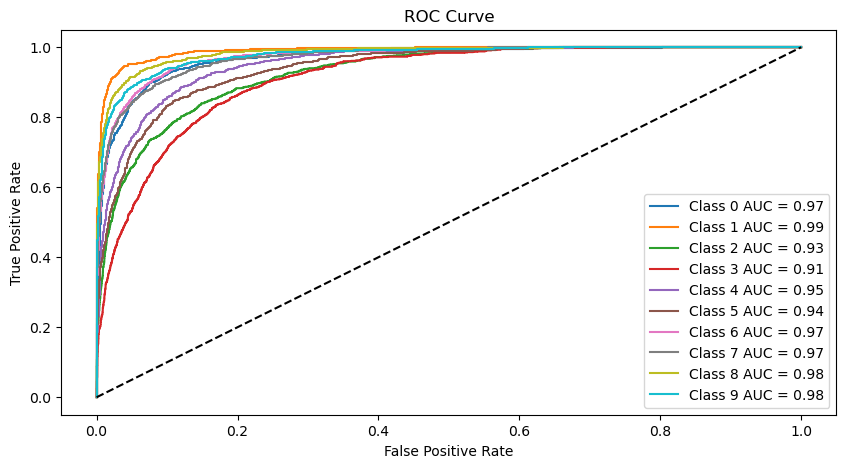

In [7]:
def evaluate_model(model, train_loader, test_loader):
    model.eval()
    # Helper function to predict probabilities and labels
    def get_predictions(loader):
        all_labels, all_preds, all_probs = [], [], []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_labels.extend(labels.numpy())
                all_preds.extend(preds.numpy())
                all_probs.extend(probs.numpy())
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)

    Y_train, Y_train_pred, Y_train_prob = get_predictions(train_loader)
    Y_test, Y_test_pred, Y_test_prob = get_predictions(test_loader)

    # Compute and print metrics
    print("Training Metrics:")
    print("Accuracy:", accuracy_score(Y_train, Y_train_pred))
    print("Precision (macro):", precision_score(Y_train, Y_train_pred, average='macro'))
    print("Recall (macro):", recall_score(Y_train, Y_train_pred, average='macro'))

    print("Test Metrics:")
    print("Accuracy:", accuracy_score(Y_test, Y_test_pred))
    print("Precision (macro):", precision_score(Y_test, Y_test_pred, average='macro'))
    print("Recall (macro):", recall_score(Y_test, Y_test_pred, average='macro'))

    # ROC and AUC
    plt.figure(figsize=(10, 5))
    for i in range(10):
        fpr, tpr, _ = roc_curve((Y_test == i).astype(int), Y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model
evaluate_model(model, train_loader, test_loader)


### Improvement 1: Batch Normalization

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Training Loss: 1.8884, Validation Loss: 1.6578
Epoch [2/15], Training Loss: 1.7116, Validation Loss: 1.5258
Epoch [3/15], Training Loss: 1.6031, Validation Loss: 1.4563
Epoch [4/15], Training Loss: 1.4996, Validation Loss: 1.4274
Epoch [5/15], Training Loss: 1.4141, Validation Loss: 1.2212
Epoch [6/15], Training Loss: 1.3393, Validation Loss: 1.2991
Epoch [7/15], Training Loss: 1.2786, Validation Loss: 1.3265
Epoch [8/15], Training Loss: 1.2175, Validation Loss: 1.1395
Epoch [9/15], Training Loss: 1.1770, Validation Loss: 1.0473
Epoch [10/15], Training Loss: 1.1341, Validation Loss: 1.0777
Epoch [11/15], Training Loss: 1.0984, Validation Loss: 0.9417
Epoch [12/15], Training Loss: 1.0634, Validation Loss: 1.0037
Epoch [13/15], Training Loss: 1.0392, Validation Loss: 0.8912
Epoch [14/15], Training Loss: 1.0113, Validation Loss: 0.9315
Epoch [15/15], Training Loss: 0.9922, Validation Loss: 0.9051
Tra

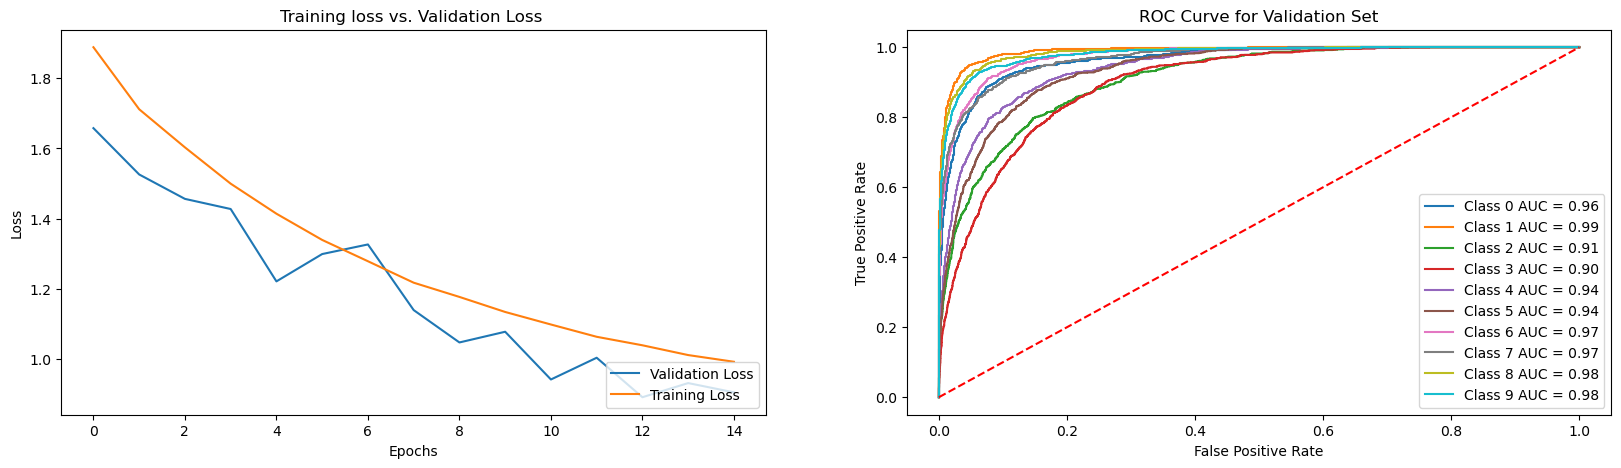

In [6]:
import torchvision
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)



# convert to nparray and normalize 
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomRotation(10),            # random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2,    # random changes in brightness, contrast, etc.
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),                    # ronvert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),    # ormalize to [-1, 1]
                         (0.5, 0.5, 0.5))
])

# get dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
###########################################################
## Improvement 1: Batch Normalization
###########################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer after first convolution
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch normalization layer after second convolution
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization layer after third convolution
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply BN before activation
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply BN before activation
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply BN before activation
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
###########################################################
##                                                      ##
###########################################################
    
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer =optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train_model(model, train_loader, valid_loader, loss_function, optimizer, num_epochs=5):
    train_loss_list = []  # Initialize an empty list to store the average training loss per epoch
    valid_loss_list = []  # Initilaise an empty list to store the average validation loss per epoch 
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_train, y_train in train_loader:
            optimizer.zero_grad()            # Zero the gradients
            outputs = model(X_train)         # Forward pass
            loss = loss_function(outputs, y_train)  # Compute loss
            loss.backward()                  # Backward pass
            optimizer.step()                 # Update weights
            train_loss += loss.item()
        
        # Compute and save the average train loss for this epoch
        average_train_loss = train_loss / len(train_loader)
        train_loss_list.append(average_train_loss)

        # Loop for validation 
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                valid_outputs = model(X_valid)                              # Forward pass
                valid_loss += loss_function(valid_outputs, y_valid).item()  # Compute loss
       
        # Compute avergae validation loss for this epoch 
        average_valid_loss = valid_loss / len(valid_loader)
        valid_loss_list.append(average_valid_loss)
            
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")
    
    print("Training Complete!")
    return train_loss_list, valid_loss_list  # Return the loss list


# Function to evaluate the model
def evaluate_model(model, train_loader, test_loader, loss_list):
    model.eval()  # Explicitly set to evaluation mode
    
    # Helper function to predict probabilities and labels
    def get_predictions(loader):
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Probabilities
                preds = torch.argmax(probs, dim=1)     # Predicted labels
                
                all_labels.extend(labels.numpy())
                all_preds.extend(preds.numpy())
                all_probs.extend(probs.numpy())
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)
    
    # Predict on Train and Test Datasets
    Y_train, Y_train_pred, Y_train_prob = get_predictions(train_loader)
    Y_test, Y_test_pred, Y_test_prob = get_predictions(test_loader)
    
    # Compute Training Metrics
    print("\nModel Performance -")
    print("Training Accuracy:", round(accuracy_score(Y_train, Y_train_pred), 3))
    print("Training Precision (macro):", round(precision_score(Y_train, Y_train_pred, average='macro'), 3))
    print("Training Recall (macro):", round(recall_score(Y_train, Y_train_pred, average='macro'), 3))

    # Compute Validation Metrics
    print("Validation Accuracy:", round(accuracy_score(Y_test, Y_test_pred), 3))
    print("Validation Precision (macro):", round(precision_score(Y_test, Y_test_pred, average='macro'), 3))
    print("Validation Recall (macro):", round(recall_score(Y_test, Y_test_pred, average='macro'), 3))
    
    # Plot the Training and Validation Loss Curves
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(valid_loss_list, label="Validation Loss") # line only 
    plt.plot(train_loss_list, label="Training Loss")   # line only 
    plt.title('Training loss vs. Validation Loss ')    # name of graph 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    
    # Plot ROC Curves (One-vs-Rest for Multi-Class)
    plt.subplot(1, 2, 2)
    for i in range(10):  # 10 classes
        fpr, tpr, _ = roc_curve((Y_test == i).astype(int), Y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('ROC Curve for Validation Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



train_loss_list, valid_loss_list = train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs=15)
evaluate_model(model,train_loader, test_loader, train_loss_list)


# output

### Improvement 2: Learning Rate Scheduler

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Training Loss: 1.8884, Validation Loss: 1.6578
Epoch [2/15], Training Loss: 1.7116, Validation Loss: 1.5258
Epoch [3/15], Training Loss: 1.6031, Validation Loss: 1.4563
Epoch [4/15], Training Loss: 1.4996, Validation Loss: 1.4274
Epoch [5/15], Training Loss: 1.4141, Validation Loss: 1.2212
Epoch [6/15], Training Loss: 1.3393, Validation Loss: 1.2991
Epoch [7/15], Training Loss: 1.2786, Validation Loss: 1.3265
Epoch [8/15], Training Loss: 1.2175, Validation Loss: 1.1395
Epoch [9/15], Training Loss: 1.1770, Validation Loss: 1.0473
Epoch [10/15], Training Loss: 1.1341, Validation Loss: 1.0777
Epoch [11/15], Training Loss: 1.0984, Validation Loss: 0.9417
Epoch [12/15], Training Loss: 1.0634, Validation Loss: 1.0037
Epoch [13/15], Training Loss: 1.0392, Validation Loss: 0.8912
Epoch [14/15], Training Loss: 1.0113, Validation Loss: 0.9315
Epoch [15/15], Training Loss: 0.9922, Validation Loss: 0.9051
Tra

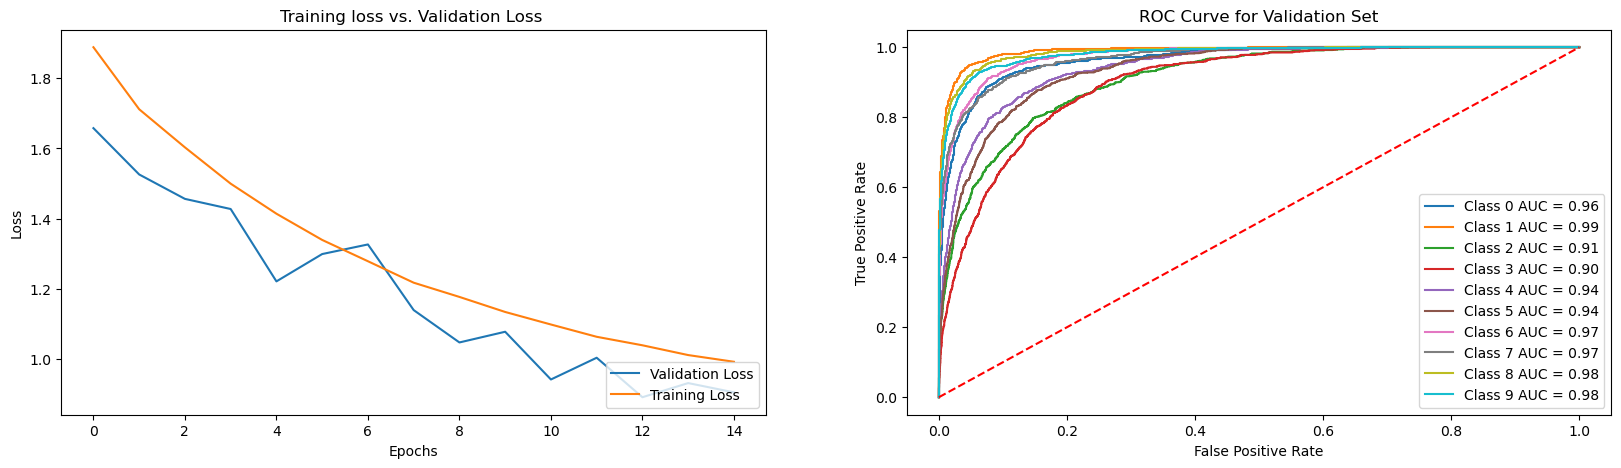

In [8]:
import torchvision
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)



# convert to nparray and normalize 
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomRotation(10),            # random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2,    # random changes in brightness, contrast, etc.
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),                    # ronvert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),    # ormalize to [-1, 1]
                         (0.5, 0.5, 0.5))
])

# get dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
###########################################################
## Improvement 1: Batch Normalization
###########################################################
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer after first convolution
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch normalization layer after second convolution
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization layer after third convolution
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply BN before activation
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply BN before activation
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply BN before activation
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
###########################################################
##                                                      ##
###########################################################
    
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer =optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


###########################################################
##          Improvemenet 2:  Learning Rate Scheduler
###########################################################
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduces the learning rate by a factor of 0.1 every 10 epochs


def train_model(model, train_loader, loss_function, optimizer, scheduler, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_train, y_train in train_loader:
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = loss_function(outputs, y_train)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        scheduler.step()  # Update the learning rate
        
        average_train_loss = train_loss / len(train_loader)
        train_loss_list.append(average_train_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_train_loss:.4f}")
    
    print("Training Complete!")
    return train_loss_list  # Return the loss list

###########################################################
##                                                      ##
###########################################################

def train_model(model, train_loader, valid_loader, loss_function, optimizer, num_epochs=5):
    train_loss_list = []  # Initialize an empty list to store the average training loss per epoch
    valid_loss_list = []  # Initilaise an empty list to store the average validation loss per epoch 
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_train, y_train in train_loader:
            optimizer.zero_grad()            # Zero the gradients
            outputs = model(X_train)         # Forward pass
            loss = loss_function(outputs, y_train)  # Compute loss
            loss.backward()                  # Backward pass
            optimizer.step()                 # Update weights
            train_loss += loss.item()
        
        # Compute and save the average train loss for this epoch
        average_train_loss = train_loss / len(train_loader)
        train_loss_list.append(average_train_loss)

        # Loop for validation 
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                valid_outputs = model(X_valid)                              # Forward pass
                valid_loss += loss_function(valid_outputs, y_valid).item()  # Compute loss
       
        # Compute avergae validation loss for this epoch 
        average_valid_loss = valid_loss / len(valid_loader)
        valid_loss_list.append(average_valid_loss)
            
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")
    
    print("Training Complete!")
    return train_loss_list, valid_loss_list  # Return the loss list


# Function to evaluate the model
def evaluate_model(model, train_loader, test_loader, loss_list):
    model.eval()  # Explicitly set to evaluation mode
    
    # Helper function to predict probabilities and labels
    def get_predictions(loader):
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Probabilities
                preds = torch.argmax(probs, dim=1)     # Predicted labels
                
                all_labels.extend(labels.numpy())
                all_preds.extend(preds.numpy())
                all_probs.extend(probs.numpy())
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)
    
    # Predict on Train and Test Datasets
    Y_train, Y_train_pred, Y_train_prob = get_predictions(train_loader)
    Y_test, Y_test_pred, Y_test_prob = get_predictions(test_loader)
    
    # Compute Training Metrics
    print("\nModel Performance -")
    print("Training Accuracy:", round(accuracy_score(Y_train, Y_train_pred), 3))
    print("Training Precision (macro):", round(precision_score(Y_train, Y_train_pred, average='macro'), 3))
    print("Training Recall (macro):", round(recall_score(Y_train, Y_train_pred, average='macro'), 3))

    # Compute Validation Metrics
    print("Validation Accuracy:", round(accuracy_score(Y_test, Y_test_pred), 3))
    print("Validation Precision (macro):", round(precision_score(Y_test, Y_test_pred, average='macro'), 3))
    print("Validation Recall (macro):", round(recall_score(Y_test, Y_test_pred, average='macro'), 3))
    
    # Plot the Training and Validation Loss Curves
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(valid_loss_list, label="Validation Loss") # line only 
    plt.plot(train_loss_list, label="Training Loss")   # line only 
    plt.title('Training loss vs. Validation Loss ')    # name of graph 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    
    # Plot ROC Curves (One-vs-Rest for Multi-Class)
    plt.subplot(1, 2, 2)
    for i in range(10):  # 10 classes
        fpr, tpr, _ = roc_curve((Y_test == i).astype(int), Y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('ROC Curve for Validation Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



train_loss_list, valid_loss_list = train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs=15)
evaluate_model(model,train_loader, test_loader, train_loss_list)


# output
       

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Training Loss: 2.1103, Validation Loss: 1.9250
Epoch [2/15], Training Loss: 1.8340, Validation Loss: 1.7126
Epoch [3/15], Training Loss: 1.6794, Validation Loss: 1.6083
Epoch [4/15], Training Loss: 1.5570, Validation Loss: 1.4356
Epoch [5/15], Training Loss: 1.4445, Validation Loss: 1.3638
Epoch [6/15], Training Loss: 1.3640, Validation Loss: 1.3486
Epoch [7/15], Training Loss: 1.2901, Validation Loss: 1.1683
Epoch [8/15], Training Loss: 1.2266, Validation Loss: 1.1735
Epoch [9/15], Training Loss: 1.1723, Validation Loss: 1.1141
Epoch [10/15], Training Loss: 1.1225, Validation Loss: 1.0534
Epoch [11/15], Training Loss: 1.0770, Validation Loss: 1.0280
Epoch [12/15], Training Loss: 1.0450, Validation Loss: 0.9650
Epoch [13/15], Training Loss: 1.0145, Validation Loss: 0.9756
Epoch [14/15], Training Loss: 0.9817, Validation Loss: 0.9116
Epoch [15/15], Training Loss: 0.9524, Validation Loss: 0.9043
Tra

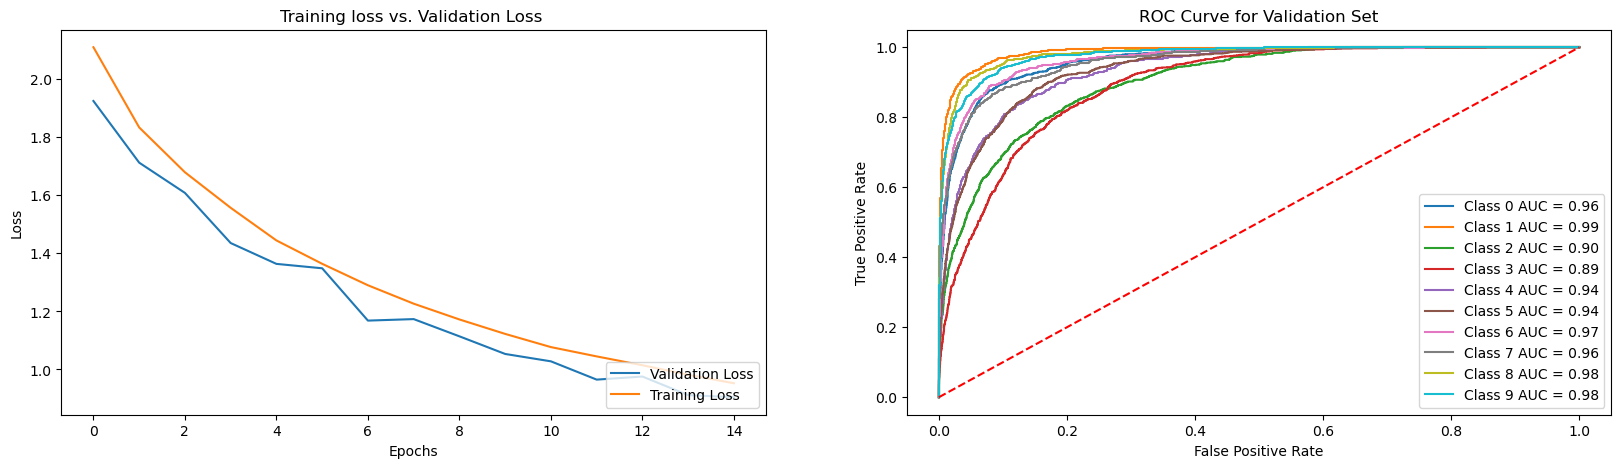

In [6]:
import torchvision
from torchvision.transforms import transforms
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)



# convert to nparray and normalize 
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # random crop with padding
    transforms.RandomRotation(10),            # random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2,    # random changes in brightness, contrast, etc.
                           contrast=0.2, 
                           saturation=0.2, 
                           hue=0.1),
    transforms.ToTensor(),                    # ronvert to tensor
    transforms.Normalize((0.5, 0.5, 0.5),    # ormalize to [-1, 1]
                         (0.5, 0.5, 0.5))
])

# get dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        # Adjusted the number of input features to match the output of global_pool
        self.fc1 = nn.Linear(128, 256)  # Changed from 2048 to 128
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


    
model = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adding weight decay for L2 regularization


def train_model(model, train_loader, valid_loader, loss_function, optimizer, num_epochs=5):
    train_loss_list = []  # Initialize an empty list to store the average training loss per epoch
    valid_loss_list = []  # Initilaise an empty list to store the average validation loss per epoch 
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for X_train, y_train in train_loader:
            optimizer.zero_grad()            # Zero the gradients
            outputs = model(X_train)         # Forward pass
            loss = loss_function(outputs, y_train)  # Compute loss
            loss.backward()                  # Backward pass
            optimizer.step()                 # Update weights
            train_loss += loss.item()
        
        # Compute and save the average train loss for this epoch
        average_train_loss = train_loss / len(train_loader)
        train_loss_list.append(average_train_loss)

        # Loop for validation 
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                valid_outputs = model(X_valid)                              # Forward pass
                valid_loss += loss_function(valid_outputs, y_valid).item()  # Compute loss
       
        # Compute avergae validation loss for this epoch 
        average_valid_loss = valid_loss / len(valid_loader)
        valid_loss_list.append(average_valid_loss)
            
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")
    
    print("Training Complete!")
    return train_loss_list, valid_loss_list  # Return the loss list






# Function to evaluate the model
def evaluate_model(model, train_loader, test_loader, loss_list):
    model.eval()  # Explicitly set to evaluation mode
    
    # Helper function to predict probabilities and labels
    def get_predictions(loader):
        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Probabilities
                preds = torch.argmax(probs, dim=1)     # Predicted labels
                
                all_labels.extend(labels.numpy())
                all_preds.extend(preds.numpy())
                all_probs.extend(probs.numpy())
        return np.array(all_labels), np.array(all_preds), np.array(all_probs)
    
    # Predict on Train and Test Datasets
    Y_train, Y_train_pred, Y_train_prob = get_predictions(train_loader)
    Y_test, Y_test_pred, Y_test_prob = get_predictions(test_loader)
    
    # Compute Training Metrics
    print("\nModel Performance -")
    print("Training Accuracy:", round(accuracy_score(Y_train, Y_train_pred), 3))
    print("Training Precision (macro):", round(precision_score(Y_train, Y_train_pred, average='macro'), 3))
    print("Training Recall (macro):", round(recall_score(Y_train, Y_train_pred, average='macro'), 3))

    # Compute Validation Metrics
    print("Validation Accuracy:", round(accuracy_score(Y_test, Y_test_pred), 3))
    print("Validation Precision (macro):", round(precision_score(Y_test, Y_test_pred, average='macro'), 3))
    print("Validation Recall (macro):", round(recall_score(Y_test, Y_test_pred, average='macro'), 3))
    
    # Plot the Training and Validation Loss Curves
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(valid_loss_list, label="Validation Loss") # line only 
    plt.plot(train_loss_list, label="Training Loss")   # line only 
    plt.title('Training loss vs. Validation Loss ')    # name of graph 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    
    # Plot ROC Curves (One-vs-Rest for Multi-Class)
    plt.subplot(1, 2, 2)
    for i in range(10):  # 10 classes
        fpr, tpr, _ = roc_curve((Y_test == i).astype(int), Y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.title('ROC Curve for Validation Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



train_loss_list, valid_loss_list = train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs=15)
evaluate_model(model,train_loader, test_loader, train_loss_list)


# output

